In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
import shapely
import rasterio
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from pathlib import Path

from shapely import affinity
from shapely.geometry.multipolygon import MultiPolygon
from scipy.spatial import Voronoi

In [2]:
weight_wind = [
    0.057, #landuse
    0.044, #slope
    0.088, #elevation
    0.071, #d to settlement
    0.044, #d to wetland
    0.055, #d to forest
    0.044, #prox to road
    0.088, #prox to sub
    0.261, #Resource quality
    0.247 #Farm Required area
    ]
print(sum(weight_wind))

weight_solar = [
    0.140, #landuse
    0.126, #slope
    0.063, #elevation
    0.057, #d to settlement
    0.0495, #d to wetland
    0.0275, #d to forest
    0.047, #prox to road
    0.099, #prox to sub
    0.254, #Resource quality
    0.135 #Farm Required area
    ]
print(sum(weight_solar))

0.999
0.998


In [3]:
## Create teh final SI map template ###
xr_final_SI = xr.open_dataset('Output\\xr_SI_Landcover.nc')
xr_final_SI = xr_final_SI.drop_vars('lccs_class')
xr_final_SI = xr_final_SI.drop_vars('SI_BGEC')
xr_final_SI = xr_final_SI.drop_vars('SI_Biomass')
xr_final_SI = xr_final_SI.drop_vars('SI_BGWW')
xr_final_SI = xr_final_SI.drop_vars('SI_MSW')
xr_final_SI = xr_final_SI.drop_vars('SI_IEW')
xr_final_SI = xr_final_SI.drop_vars('aux')

xr_final_SI['AVA_Wind'] = xr_final_SI['SI_Wind']
xr_final_SI['AVA_Solar'] = xr_final_SI['SI_Solar']

xr_final_SI['SI_Wind'] = 0.0
xr_final_SI['SI_Solar'] = 0.0
xr_final_SI['AVA_Wind'] = 0.0
xr_final_SI['AVA_Solar'] = 0.0
print(xr_final_SI)
check_weight_wind = 0
check_weight_solar = 0

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   float64 0.0
    SI_Wind    float64 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   float64 0.0
    AVA_Solar  float64 0.0


<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.057
check w solar =  0.14
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(148914.99)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(148914.99)


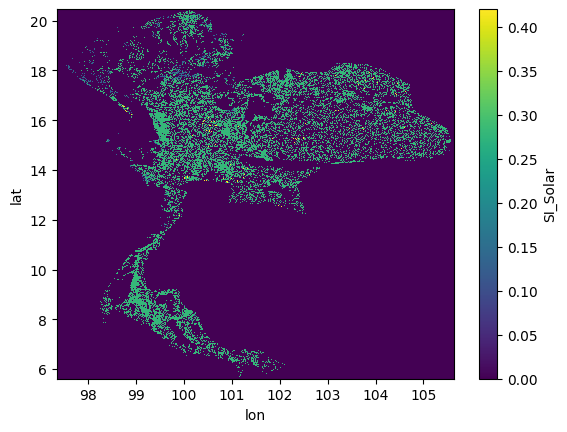

In [4]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_landuse_suitability_index['SI_Wind'] * weight_wind[0])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_landuse_suitability_index['SI_Solar'] * weight_solar[0])
xr_final_SI['AVA_Wind'] = xr.where(xr_landuse_suitability_index['SI_Wind'] > 0 ,0.09,0)
xr_final_SI['AVA_Solar'] = xr.where(xr_landuse_suitability_index['SI_Solar'] > 0 ,0.09,0)

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[0]
check_weight_solar = check_weight_solar + weight_solar[0]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

xr_final_SI['SI_Solar'].plot()

In [5]:
xr_cal = xr.open_dataset('Output\\xr_SI_Slope.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[1])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[1])

# cutout area for slope 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[1]
check_weight_solar = check_weight_solar + weight_solar[1]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.101
check w solar =  0.266
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(142577.37)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(123109.92)


In [6]:
xr_cal = xr.open_dataset('Output\\xr_SI_Elevation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[2])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[2])
## NO Cutout area for elevation 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['suitability_index'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['suitability_index'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[2]
check_weight_solar = check_weight_solar + weight_solar[2]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.189
check w solar =  0.329
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(142577.37)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(123109.92)


In [7]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosettlementarea.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[3])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[3])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[3]
check_weight_solar = check_weight_solar + weight_solar[3]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.26
check w solar =  0.386
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(134858.97)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(115525.71)


In [8]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetowetland.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[4])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[4])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[4]
check_weight_solar = check_weight_solar + weight_solar[4]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.304
check w solar =  0.4355
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(131209.2)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(112024.44)


In [9]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoforest.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[5])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[5])

xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[5]
check_weight_solar = check_weight_solar + weight_solar[5]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.359
check w solar =  0.463
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86647.59)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90427.5)


In [10]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoroad.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[6])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[6])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[6]
check_weight_solar = check_weight_solar + weight_solar[6]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.40299999999999997
check w solar =  0.51
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86268.78)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90047.61)


In [11]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosubstation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[7])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[7])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[7]
check_weight_solar = check_weight_solar + weight_solar[7]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.491
check w solar =  0.609
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86268.78)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90047.61)


In [12]:
xr_cal = xr.open_dataset('Output\\xr_SI_resourcepotential.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[8])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[8])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar']  == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'].astype('float32')
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'].astype('float32')
xr_final_SI['AVA_Wind'] = xr_final_SI['AVA_Wind'].astype('float32')
xr_final_SI['AVA_Solar'] = xr_final_SI['AVA_Solar'].astype('float32')

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[8]
check_weight_solar = check_weight_solar + weight_solar[8]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

xr_final_SI['SI_Solar'].plot()

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    distance   (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.752
check w solar =  0.863
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86264.34, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90046.14, dtype=float32)


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_8256\2922164285.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  existingplants['area'] = existingplants['geometry'].buffer(0.05)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis or

AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(70533.664, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(73742.92, dtype=float32)


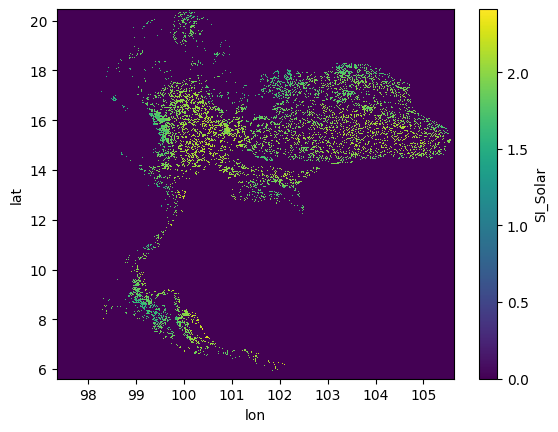

In [ ]:
### First, I exclude existing plant and RE Biglot #### 
existingplants = pd.read_csv("Data\\ExistingPlants_wPosition.csv")
existingplants = gpd.GeoDataFrame(existingplants, geometry =gpd.points_from_xy(existingplants['longitude'],existingplants['latitude']))
existingplants.crs = {'init': 'epsg:4326'}
# existingplants = existingplants.loc[existingplants['EXP_MW'] >= 1]
existingplants.reset_index(inplace=True,drop=True)
        
for i in existingplants.columns:
    if i not in ['Sale_MW','FuelTypeName','latitude','longitude','geometry']:
        existingplants = existingplants.drop(columns=i)

existingplants['area'] = existingplants['geometry'].buffer(0.05)

REbiglot = pd.read_excel('Data\\NewVRE.xlsx',sheet_name='สรุปผู้ที่ได้รับการคัดเลือก')
REbiglot = gpd.GeoDataFrame(REbiglot, geometry =gpd.points_from_xy(REbiglot['lon'],REbiglot['lat']))
REbiglot.crs = {'init': 'epsg:4326'}
REbiglot.reset_index(inplace=True,drop=True)

REbiglot['area'] = REbiglot['geometry'].buffer(0.05)

df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI['aux'] = 1

for i in range(len(existingplants)) :
    df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(existingplants['area'][i]))] = 0

for i in range(len(REbiglot)) :
    df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(REbiglot['area'][i]))] = 0

df_final_SI['SI_Wind'] = df_final_SI['SI_Wind'] * df_final_SI['aux']
df_final_SI['SI_Solar'] = df_final_SI['SI_Solar'] * df_final_SI['aux']
df_final_SI['AVA_Wind'] = df_final_SI['AVA_Wind'] * df_final_SI['aux']
df_final_SI['AVA_Solar'] = df_final_SI['AVA_Solar'] * df_final_SI['aux']

df_final_SI = df_final_SI.drop(columns=['aux','geometry'])
df_final_SI = df_final_SI.set_index(['lat', 'lon'])
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
xr_final_SI['SI_Solar'].plot()

#############################################################################################################################